<a href="https://colab.research.google.com/github/krystianjablonowski/kwant-tutorials-zps/blob/master/2023-04-18-Lieb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Co ja myśle to i powiem

In [ ]:
!pip3 install kwant

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 16.4 MB/s 
  Created wheel for kwant: filename=kwant-1.4.3-cp37-cp37m-linux_x86_64.whl size=3691012 sha256=31e343e87c9ef51a91059ef555117b707eb156b47f6a486eceda7a0996392797
  Stored in directory: /root/.cache/pip/wheels/d6/2d/93/6f395cd3f0798d7d9e161dce1c8b8c8bbd04d4547763c926de
  Created wheel for tinyarray: filename=tinyarray-1.2.4-cp37-cp37m-linux_x86_64.whl size=228004 sha256=11162479bbd7566c2997f0c6d5f9691029bdc35025cedc344dee9d681c9bc734
  Stored in directory: /root/.cache/pip/wheels/85/c6/1c/6939e2931cfbff5df75758a06084bf67171b640ebdf5febd35
Successfully built kwant tinyarray


In [ ]:
import kwant
import matplotlib
import matplotlib.pyplot as plt

import scipy as scp
import numpy as np
from kwant.physics import dispersion
from scipy import sparse as sp



def make_system(a=1, t_1=1.0, t_2=1.0, L=10,lead=True):
    lat = kwant.lattice.Polyatomic([[2*a, 0],[0,2*a]], [[0, 0],[0,a],[a,0]],norbs=1)
    lat.a, lat.b, lat.c = lat.sublattices
    
    syst = kwant.Builder()
    # Onsites
    syst[(lat.a(n,m) for n in range(L) for m in range(L))] = 0
    syst[(lat.b(n,m) for n in range(L) for m in range(L))] = 0
    syst[(lat.c(n,m) for n in range(L) for m in range(L))] = 0
    # Hopping t1
    syst[((lat.a(n,m), lat.b(n,m)) for n in range(L) for m in range(L))] = t_1
    syst[((lat.a(n,m), lat.c(n,m)) for n in range(L) for m in range(L))] = t_1
    syst[((lat.b(n,m), lat.c(n,m)) for n in range(L) for m in range(L))] = t_2
    syst[((lat.b(n+1,m), lat.c(n,m)) for n in range(L-1) for m in range(L))] = t_2
    syst[((lat.b(n,m-1), lat.c(n,m)) for n in range(L) for m in range(1,L))] = t_2
    syst[((lat.b(n-1,m+1), lat.c(n,m)) for n in range(1,L) for m in range(L-1))] = t_2
    syst[((lat.b(n,m), lat.a(n,m+1)) for n in range(L) for m in range(L-1))] = t_1
    syst[((lat.c(n,m), lat.a(n+1,m)) for n in range(L-1) for m in range(L))] = t_1
    # Hopping t2
   # syst[((lat.b(n-1), lat.a(n)) for n in range(1,L))] = t_1
    if(lead==False):
      return syst,lat


    # Left lead
    sym_left_lead = kwant.TranslationalSymmetry([-2*a, 0])
    left_lead = kwant.Builder(sym_left_lead)
      # Onsites
    left_lead[(lat.a(n,m) for n in range(L) for m in range(L))] = 0
    left_lead[(lat.b(n,m) for n in range(L) for m in range(L))] = 0
    left_lead[(lat.c(n,m) for n in range(L) for m in range(L))] = 0
    # Hopping t1
    left_lead[((lat.a(n,m), lat.b(n,m)) for n in range(L) for m in range(L))] = t_1
    left_lead[((lat.a(n,m), lat.c(n,m)) for n in range(L) for m in range(L))] = t_1
    left_lead[((lat.b(n,m), lat.c(n,m)) for n in range(L) for m in range(L))] = t_2
    left_lead[((lat.b(n+1,m), lat.c(n,m)) for n in range(L-1) for m in range(L))] = t_2
    left_lead[((lat.b(n,m-1), lat.c(n,m)) for n in range(L) for m in range(1,L))] = t_2
    left_lead[((lat.b(n-1,m+1), lat.c(n,m)) for n in range(1,L) for m in range(L-1))] = t_2
    left_lead[((lat.b(n,m), lat.a(n,m+1)) for n in range(L) for m in range(L-1))] = t_1
    left_lead[((lat.c(n,m), lat.a(n+1,m)) for n in range(L-1) for m in range(L))] = t_1
                              
    syst.attach_lead(left_lead)
    left_lead_fin = left_lead.finalized()
    
    syst.attach_lead(left_lead.reversed())
    
    # Right lead
    #sym_right_lead = kwant.TranslationalSymmetry([2*a, 0])
    #right_lead = kwant.Builder(sym_right_lead)
    #right_lead[lat.a(0)] = 0
    #right_lead[lat.b(0)] = 0
    #right_lead[lat.a(0), lat.b(0)] = t_1
    #right_lead[lat.a(0), lat.a(1)] = t_2
    #syst.attach_lead(right_lead)
    #right_lead_fin = right_lead.finalized()
    syst_fin=syst.finalized()
    return syst_fin, left_lead_fin,lat

def plot_bandstructure(flead, momenta, label=None, title=None):
    bands = kwant.physics.Bands(flead)
    energies = [bands(k) for k in momenta]
    
    plt.figure()
    plt.title(title)
    plt.plot(momenta, energies, label=label)
    plt.xlabel("momentum [(lattice constant)^-1]")
    plt.ylabel("energy [t]")
    
    
def plot_conductance(syst, energies):
    # Compute conductance
    data = []
    for energy in energies:
        smatrix = kwant.smatrix(syst, energy)
        data.append(smatrix.transmission(1, 0))

    plt.figure()
    plt.plot(energies, data)
    plt.xlabel("energy [t]")
    plt.ylabel("conductance [e^2/h]")
    plt.show()


def plot_density(sys,ener, it=-1,title="empty"):
    
    wf = kwant.wave_function(sys, energy=ener)
    
    t=np.shape(wf(0))
    nwf=wf(0)[0]*0
    
    
    for i in range(t[0]//2+1):
        test=wf(0)[i]
        nwf+=test

    psi=abs(nwf)**2
    
    if it==-1:
        title="density"
    elif it>-1:
        title= "density"
        
    title2=title+".pdf"
    
    kwant.plotter.map(sys,psi,method='linear',vmin=0,title=title)

    J_0 = kwant.operator.Current(sys)
    c = J_0(nwf)

    kwant.plotter.current(sys, c)

    plt.close()

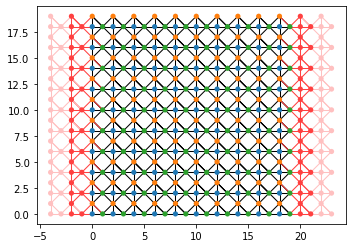

AttributeError: ignored

In [ ]:
fsyst,lead,lat= make_system(L=10,lead=True)
kwant.plot(fsyst)



#### dictionary containing the parameters
## Lead bands: calculation with a better control
#              sparse matrix diagonlization

# prepare H_0 and V for our lead
ham0  = fsyst.cell_hamiltonian(sparse=True)  #.tocsc()

_hop  = fsyst.inter_cell_hopping(sparse=True)
shp = (_hop.shape[0], _hop.shape[0] - _hop.shape[1])
_zeros = sp.coo_matrix( shp, dtype=complex)
vhop = sp.hstack( [_hop, _zeros] )                          #.tocsc()

momenta=np.linspace(-np.pi, np.pi, 301)
ens = []


for kpar in momenta:
    # H_k = H_0 + V e^-ik + V^\dagger e^ik
    hmat  = vhop * np.exp(-1j*(kpar)) 
    hmat += hmat.conjugate().transpose() + ham0
    
    #evals = la.eigh( hmat, eigvals_only=True ) ## dense solver
    evals = lsp.eigsh( hmat, k=20, return_eigenvectors=False,
                       which='LM', sigma=0.01, tol=10**(-8) )

    ens.append(np.sort(evals))


plt.grid()
#plt.xlim(-1, 1)
plt.ylim(-0.01, 0.2)
plt.xlabel('momentum [1/a]')
plt.ylabel('energy')

#plt.plot(momenta,ens,'.',ms=1)
plt.plot(momenta,ens)
plt.show()


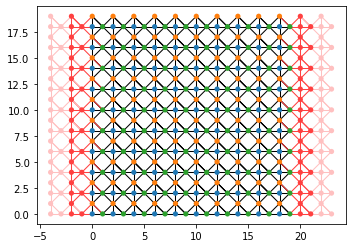

TypeError: ignored

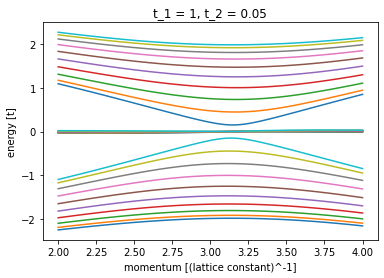

In [ ]:

sys, left_lead = make_system()
kwant.plot(sys)

    
for t_2 in np.linspace(0.05, 1, 10):
    sys, left_lead = make_system(t_1 = 1, t_2 =t_2*0.5j,)
    plot_bandstructure(left_lead, np.linspace(2,4, 100), t_2, title=f"t_1 = 1, t_2 = {t_2}")
    #plot_conductance(sys, np.linspace(0,2,1000))
    plot_density(sys, 1,title=f"t_1 = 1, t_2 = {t_2}")
    #kwant.plotter.bands(left_lead)
    
plt.show()